# PSPNet + PoseNet + ACGPN

## Dataset: VITON dataset 
    This dataset contains 16,253 image pairs, further splitting into a training set of 14,221 paris and a testing set of 2,032 pairs.

## Uploading Dataset

In [1]:
!mkdir Dataset

#### Uploading dataset in (color, edge, mask, colormask)

In [2]:
!cp -r /kaggle/input/viton-dataset/ACGPN_TestData/test_color Dataset
!cp -r /kaggle/input/viton-dataset/ACGPN_TestData/test_edge Dataset
!cp -r /kaggle/input/viton-dataset/ACGPN_TestData/test_mask Dataset
!cp -r /kaggle/input/viton-dataset/ACGPN_TestData/test_colormask Dataset

#### Uploading TestData (image, pose, label)

In [3]:
!cp -r /kaggle/input/tryon-testdata/Dataset/test_img Dataset
!cp -r /kaggle/input/tryon-testdata/Dataset/test_pose Dataset
!cp -r /kaggle/input/tryon-testdata/Dataset/test_label Dataset
!rm Dataset/test_pose/*
!rm Dataset/test_label/*

# Semantic Segmentation using PSPNet

In [4]:
!git clone https://github.com/rkuo2000/semantic-segmentation-pytorch 
%cd semantic-segmentation-pytorch

Cloning into 'semantic-segmentation-pytorch'...
remote: Enumerating objects: 530, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 530 (delta 185), reused 174 (delta 174), pack-reused 337
Receiving objects: 100% (530/530), 37.47 MiB | 9.21 MiB/s, done.
Resolving deltas: 100% (293/293), done.
/kaggle/working/semantic-segmentation-pytorch


### Importing Important Libs

In [5]:
from torchvision import transforms
from segmentation.data_loader.segmentation_dataset import SegmentationDataset
from segmentation.data_loader.transform import Rescale, ToTensor
from segmentation.trainer import Trainer
from segmentation.predict import *
from segmentation.models import all_models
from util.logger import Logger

In [6]:
import os
from torchvision import transforms

from segmentation.data_loader.segmentation_dataset import SegmentationDataset
from segmentation.data_loader.transform import Rescale, ToTensor
from segmentation.trainer import Trainer
from segmentation.predict import *
from segmentation.models import all_models
from util.logger import Logger
import matplotlib.pyplot as plt

In [7]:
model_name = "pspnet_mobilenet_v2"
device = 'cuda'
batch_size = 4
n_classes = 34 
check_point_stride = 1 # store checkpoints every 1 epoch   
image_axis_minimum_size = 200

num_epochs = 1    # 1 for 1st training
                  # n for retraining
                  # 0 for detect-only
pretrained = False# True  for num_epochs=1 without logger.load_model below
                  # False for num_epochs=n with    logger.load_model below
                  # False for detect-only  with    logger.load_model below
fixed_feature = False

logger = Logger(model_name=model_name, data_name='example')

In [8]:
train_images = '/kaggle/input/viton-dataset/ACGPN_TrainData/train_img'
train_labled = '/kaggle/input/viton-dataset/ACGPN_TrainData/train_label'
test_images  = '/kaggle/input/viton-dataset/ACGPN_TestData/test_img'
test_labeled = '/kaggle/input/viton-dataset/ACGPN_TestData/test_label'

In [9]:
compose = transforms.Compose([Rescale(image_axis_minimum_size),ToTensor()])

train_datasets = SegmentationDataset(train_images, train_labled, n_classes, compose)
train_loader = torch.utils.data.DataLoader(train_datasets, batch_size=batch_size, shuffle=True, drop_last=True)

test_datasets = SegmentationDataset(test_images, test_labeled, n_classes, compose)
test_loader = torch.utils.data.DataLoader(test_datasets, batch_size=batch_size, shuffle=True, drop_last=True)

100%|████████████████████████████████████| 14221/14221 [01:26<00:00, 164.26it/s]


Dataset verified! 


100%|██████████████████████████████████████| 2032/2032 [00:17<00:00, 114.11it/s]

Dataset verified! 


### Build Model

In [10]:
### Model
model = all_models.model_from_name[model_name](n_classes, batch_size, 
                                               pretrained=pretrained, 
                                               fixed_feature=fixed_feature)
model.to(device)

# Optimizers
if pretrained and fixed_feature: #fine-tunning
    params_to_update = model.parameters()
    print("Params to learn:")
    params_to_update = []
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t", name)
    optimizer = torch.optim.Adadelta(params_to_update)
else:
    optimizer = torch.optim.Adadelta(model.parameters())

In [11]:
!mkdir -p runs/models/pspnet_mobilenet_v2/example
!cp  /kaggle/input/pspnet-viton-checkpoints/epoch_0 runs/models/pspnet_mobilenet_v2/example

logger.load_model(model, 'epoch_0') 

### Train Model

In [12]:
## Train
trainer = Trainer(model, optimizer, logger, num_epochs, train_loader, test_loader, check_point_epoch_stride=check_point_stride)
trainer.train()
print(os.listdir('runs/models/'+model_name+'/example'))

Train: 100%|█████████████████████████████████████| 1/1 [14:50<00:00, 890.84s/it]

['epoch_0']


### Saving And Loading Model

In [13]:
## Loader
compose = transforms.Compose([Rescale(image_axis_minimum_size),ToTensor()])

In [14]:
model_name = "pspnet_mobilenet_v2"
device = 'cuda'
batch_size = 4
n_classes = 34 
check_point_stride = 1    
image_axis_minimum_size = 200

num_epochs = 0    
pretrained = False
fixed_feature = False

logger = Logger(model_name=model_name, data_name='example')

### Segmentation Model

In [15]:
### Model
model = all_models.model_from_name[model_name](n_classes, batch_size, 
                                               pretrained=pretrained, 
                                               fixed_feature=fixed_feature)
model.to(device)

PSPnet(
  (features): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU6(inplace=True)
      (5): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=96, bias=False)


In [16]:
#Saving and Loading Checkpoints
!mkdir -p runs/models/pspnet_mobilenet_v2/example
!cp /kaggle/input/pspnet-viton-checkpoints/epoch_1 runs/models/pspnet_mobilenet_v2/example


logger.load_model(model,'epoch_1')

## Detect label (semantic segmentation)

In [17]:
test_img_file   = '../Dataset/test_img/000000_0.jpg'
test_label_file = '../Dataset/test_label/000000_0.png'

### Pridicted Values

In [18]:
predict(model, test_img_file, test_label_file )

tensor([[[[ 5.2723,  6.3288,  7.0349,  ...,  7.5054,  6.7746,  5.9738],
          [ 6.2968,  7.8555,  8.7414,  ...,  9.6500,  8.6736,  7.2959],
          [ 6.8202,  8.4845,  9.4365,  ..., 10.5492,  9.4190,  7.8087],
          ...,
          [ 4.6785,  4.8770,  5.0277,  ...,  2.5857,  2.7445,  3.6376],
          [ 4.4325,  4.5552,  4.7164,  ...,  2.5518,  2.6902,  3.5511],
          [ 4.6346,  4.7003,  4.8010,  ...,  2.9970,  3.1617,  3.8772]],

         [[-0.5992, -0.3138, -0.2301,  ...,  0.3897,  0.3455, -0.1936],
          [-0.4238, -0.6280, -0.5844,  ...,  0.3296,  0.4517,  0.1895],
          [-0.4610, -0.6397, -0.5355,  ...,  0.3618,  0.4405,  0.4066],
          ...,
          [-1.1709, -1.4272, -1.5262,  ..., -0.8571, -0.8166, -1.0958],
          [-1.2855, -1.6013, -1.7118,  ..., -0.9768, -0.9104, -1.1873],
          [-1.4019, -1.5588, -1.6279,  ..., -1.2139, -1.1509, -1.2249]],

         [[-3.3726, -3.3612, -3.3401,  ..., -3.5450, -3.5110, -3.4774],
          [-3.4942, -3.7274, -

## Show image & its label (segmentation)

In [19]:
from IPython.display import Image

### Test Image 

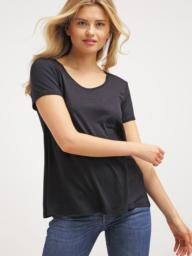

In [20]:
Image(test_img_file)

###  Result test color label

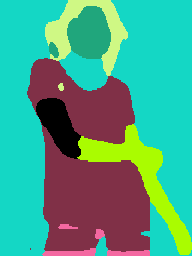

In [21]:
Image(test_label_file)

### Result In Test Gray Label

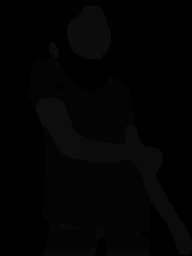

In [22]:
Image(test_label_file.replace('.png','_gray.png'))

# Gray Label to overwrite color label as test_label .png

In [23]:
!mv ../Dataset/test_label/000000_0_gray.png ../Dataset/test_label/000000_0.png

In [24]:
%cd /kaggle/working

/kaggle/working


# Pose Detection: [PoseNet](https://arxiv.org/abs/1505.07427)

![](https://github.com/tensorflow/tfjs-models/raw/master/posenet/demos/camera.gif)

In [25]:
!pip install tfjs-graph-converter

     |████████████████████████████████| 77 kB 372 kB/s 
     |████████████████████████████████| 40 kB 1.2 MB/s 
  Attempting uninstall: packaging
    Found existing installation: packaging 20.1
    Uninstalling packaging-20.1:
      Successfully uninstalled packaging-20.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bokeh 2.2.3 requires tornado>=5.1, but you have tornado 5.0.2 which is incompatible.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


### PoseNet-PyTorch

In [26]:
!git clone https://github.com/rwightman/posenet-pytorch  # fix bugs
%cd posenet-pytorch

Cloning into 'posenet-pytorch'...
remote: Enumerating objects: 115, done.
remote: Total 115 (delta 0), reused 0 (delta 0), pack-reused 115
Receiving objects: 100% (115/115), 34.73 KiB | 150.00 KiB/s, done.
Resolving deltas: 100% (62/62), done.
/kaggle/working/posenet-pytorch


In [27]:
file = '../Dataset/test_img/000000_0.jpg'

In [28]:
import torch
from posenet.constants import *
from posenet.decode_multi import decode_multiple_poses
from posenet.models.model_factory import load_model
from posenet.utils import *

net = load_model(101)
net = net.cuda()
output_stride = net.output_stride
scale_factor = 1.0

input_image, draw_image, output_scale = posenet.read_imgfile(file, scale_factor=scale_factor, output_stride=output_stride)

Cannot find models file ./_models/mobilenet_v1_101.pth, converting from tfjs...
Weights for checkpoint mobilenet_v1_101 are not downloaded. Downloading to /tmp/_posenet_weights ...


In [29]:
import torch
from posenet.constants import *
from posenet.decode_multi import decode_multiple_poses
from posenet.models.model_factory import load_model
from posenet.utils import *

net = load_model(101)
net = net.cuda()
output_stride = net.output_stride
scale_factor = 1.0

input_image, draw_image, output_scale = posenet.read_imgfile(file, scale_factor=scale_factor, output_stride=output_stride)

## Detect Pose keypoints

In [30]:
import torch
with torch.no_grad():
    input_image = torch.Tensor(input_image).cuda()

    heatmaps_result, offsets_result, displacement_fwd_result, displacement_bwd_result = net(input_image)

    pose_scores, keypoint_scores, keypoint_coords = posenet.decode_multiple_poses(
        heatmaps_result.squeeze(0),
        offsets_result.squeeze(0),
        displacement_fwd_result.squeeze(0),
        displacement_bwd_result.squeeze(0),
        output_stride=output_stride,
        max_pose_detections=10,
        min_pose_score=0.25)

### find keypoint coordinates in poses

In [31]:
import matplotlib.pyplot as plt
# read image
image = plt.imread(file)

poses = []
# find face keypoints & detect face mask
for pi in range(len(pose_scores)):
    if pose_scores[pi] != 0.:
        print('Pose #%d, score = %f' % (pi, pose_scores[pi]))       
        keypoints = keypoint_coords.astype(np.int32) # convert float to integer
        print(keypoints[pi])
        poses.append(keypoints[pi])
print(len(poses))

Pose #0, score = 0.529883
[[ 32  93]
 [ 22  99]
 [ 22  83]
 [ 33 110]
 [ 30  67]
 [ 84 115]
 [ 70  60]
 [147 139]
 [142  67]
 [199 167]
 [149 131]
 [209 127]
 [203  68]
 [266 133]
 [266  63]
 [258 143]
 [263  64]]
1


### show PoseNet keypoints

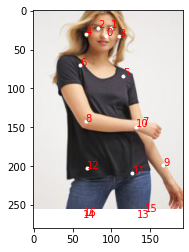

In [32]:
img = plt.imread(file)
i=0
pose = poses[0]
plt.imshow(img)    
for y,x in pose:
    plt.plot(x, y, 'w.') # 'w.': color='white', marker='.'
    plt.text(x, y, str(i), color='r', fontsize=10)
    i+=1   
plt.show()

### PoseNet output
![](https://debuggercafe.com/wp-content/uploads/2020/10/keypoint_exmp.jpg)

### OpenPose COCO format
![](https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/.github/media/keypoints_pose_18.png?raw=true)

## Convert Keypoints (from PoseNet to OpenPose)

In [33]:
# map rccpose-to-openpose mapping
indices = [0, (5,6), 6, 8, 10, 5, 7, 9, 12, 14, 16, 11, 13, 15, 2, 1, 4, 3]

In [34]:
# convert rcnnpose to openpose
i=0
openpose = []
for ix in indices:
    if ix==(5,6):
        openpose.append([int((pose[5][1]+pose[6][1])/2), int((pose[5][0]+pose[6][0])/2), 1])   
    else:
        openpose.append([int(pose[ix][1]),int(pose[ix][0]),1])        
    i+=1
    
print(openpose)

[[93, 32, 1], [87, 77, 1], [60, 70, 1], [67, 142, 1], [131, 149, 1], [115, 84, 1], [139, 147, 1], [167, 199, 1], [68, 203, 1], [63, 266, 1], [64, 263, 1], [127, 209, 1], [133, 266, 1], [143, 258, 1], [83, 22, 1], [99, 22, 1], [67, 30, 1], [110, 33, 1]]


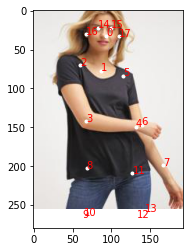

In [35]:
plt.imshow(img)
i=0
for x,y,z in openpose:
    plt.plot(x, y, 'w.') # 'w.': color='white', marker='.'
    plt.text(x, y, str(i), color='r', fontsize=10)
    i+=1
plt.show()

### save keypoints.json

In [36]:
import json
coords = []
for x,y,z in openpose:
    coords.append(float(x))
    coords.append(float(y))
    coords.append(float(z))

data = {"version": 1.0}
pose_dic = {}
pose_dic['pose_keypoints'] = coords
tmp = []
tmp.append(pose_dic)
data["people"]=tmp
print(data)

pose_name = '../Dataset/test_pose/000000_0_keypoints.json'
with open(pose_name,'w') as f:
     json.dump(data, f)  

{'version': 1.0, 'people': [{'pose_keypoints': [93.0, 32.0, 1.0, 87.0, 77.0, 1.0, 60.0, 70.0, 1.0, 67.0, 142.0, 1.0, 131.0, 149.0, 1.0, 115.0, 84.0, 1.0, 139.0, 147.0, 1.0, 167.0, 199.0, 1.0, 68.0, 203.0, 1.0, 63.0, 266.0, 1.0, 64.0, 263.0, 1.0, 127.0, 209.0, 1.0, 133.0, 266.0, 1.0, 143.0, 258.0, 1.0, 83.0, 22.0, 1.0, 99.0, 22.0, 1.0, 67.0, 30.0, 1.0, 110.0, 33.0, 1.0]}]}


## Verify _keypoints.json

In [37]:
%cd /kaggle/working

/kaggle/working


### read .json

In [38]:
# read pose
import numpy as np
import json
#pose_name = '/kaggle/input/tryon-testdata/Dataset/test_pose/000000_0_keypoints.json'
pose_name = 'Dataset/test_pose/000000_0_keypoints.json'
with open(pose_name, 'r') as f:
     pose_label = json.load(f)
     pose_data = pose_label['people'][0]['pose_keypoints']
     pose_data = np.array(pose_data)
     pose_data = pose_data.reshape((-1,3))
print(pose_data)
print(len(pose_data))

[[ 93.  32.   1.]
 [ 87.  77.   1.]
 [ 60.  70.   1.]
 [ 67. 142.   1.]
 [131. 149.   1.]
 [115.  84.   1.]
 [139. 147.   1.]
 [167. 199.   1.]
 [ 68. 203.   1.]
 [ 63. 266.   1.]
 [ 64. 263.   1.]
 [127. 209.   1.]
 [133. 266.   1.]
 [143. 258.   1.]
 [ 83.  22.   1.]
 [ 99.  22.   1.]
 [ 67.  30.   1.]
 [110.  33.   1.]]
18


### draw keypoints 

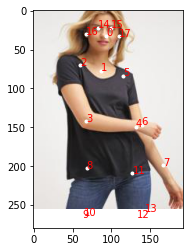

18


In [39]:
# show pose keypoints on the test image
img = plt.imread('Dataset/test_img/000000_0.jpg')
plt.imshow(img)
i=0
for x,y,z in pose_data: 
    plt.plot(x, y, 'w.') # 'w.': color='white', marker='.'
    plt.text(x, y, str(i), color='r', fontsize=10)
    i+=1
plt.show()
print(i)

# Try ON

In [40]:
!git clone https://github.com/rkuo2000/DeepFashion_Try_On
%cd DeepFashion_Try_On

Cloning into 'DeepFashion_Try_On'...
remote: Enumerating objects: 261, done.
remote: Total 261 (delta 0), reused 0 (delta 0), pack-reused 261
Receiving objects: 100% (261/261), 13.46 MiB | 6.18 MiB/s, done.
Resolving deltas: 100% (120/120), done.
/kaggle/working/DeepFashion_Try_On


### Download pre-trained model (checkpoint)

In [41]:
%cd ACGPN_inference

/kaggle/working/DeepFashion_Try_On/ACGPN_inference


In [42]:
# copy the pre-trained model (checkpoint)
!cp -rf /kaggle/input/acgpn-checkpoints/label2city checkpoints

## Test TryOn model 

In [43]:
!python test.py --dataroot ../../Dataset --color_name 000129_1.jpg

?
------------ Options -------------
batchSize: 1
beta1: 0.5
checkpoints_dir: ./checkpoints
color_name: 000129_1.jpg
continue_train: False
data_type: 32
dataroot: ../../Dataset
debug: False
display_freq: 100
display_winsize: 512
fineSize: 512
gpu_ids: [0]
input_nc: 3
isTrain: True
label_nc: 20
lambda_feat: 10.0
loadSize: 512
load_pretrain: ./checkpoints/label2city
lr: 0.0002
max_dataset_size: inf
model: pix2pixHD
nThreads: 2
n_blocks_global: 4
n_blocks_local: 3
n_downsample_global: 4
n_layers_D: 3
n_local_enhancers: 1
name: label2city
ndf: 64
netG: global
ngf: 64
niter: 100
niter_decay: 100
niter_fix_global: 0
no_flip: False
no_ganFeat_loss: False
no_html: False
no_lsgan: False
no_vgg_loss: False
norm: instance
num_D: 2
output_nc: 3
phase: test
pool_size: 0
print_freq: 100
resize_or_crop: scale_width
save_epoch_freq: 10
save_latest_freq: 1000
serial_batches: False
tf_log: False
use_dropout: False
verbose: False
which_epoch: latest
-------------- End ----------------
CustomDatasetDataLo

#### output : sample/000000_0.jpg

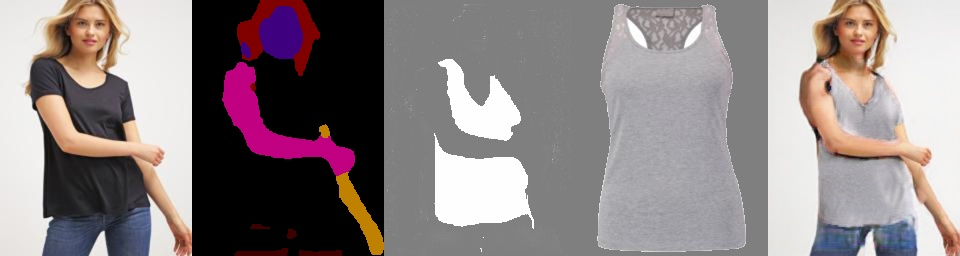

In [44]:
from IPython.display import Image
Image('./sample/000000_0.jpg')

### Display TryOn result

In [45]:
!mkdir -p ../Data_preprocessing

In [46]:
!cp -rf /kaggle/input/viton-dataset/ACGPN_TestData/* ../Data_preprocessing

In [47]:
!ls ../Data_preprocessing

readme.txt  test_colormask  test_img	test_mask
test_color  test_edge	    test_label	test_pose


# Model Modified Outputs

In [48]:

!cp -rf /kaggle/input/acgpn-checkpoints/label2city checkpoints

In [49]:
!python test.py

?
------------ Options -------------
batchSize: 1
beta1: 0.5
checkpoints_dir: ./checkpoints
color_name: 014379_1.jpg
continue_train: False
data_type: 32
dataroot: ../Data_preprocessing/
debug: False
display_freq: 100
display_winsize: 512
fineSize: 512
gpu_ids: [0]
input_nc: 3
isTrain: True
label_nc: 20
lambda_feat: 10.0
loadSize: 512
load_pretrain: ./checkpoints/label2city
lr: 0.0002
max_dataset_size: inf
model: pix2pixHD
nThreads: 2
n_blocks_global: 4
n_blocks_local: 3
n_downsample_global: 4
n_layers_D: 3
n_local_enhancers: 1
name: label2city
ndf: 64
netG: global
ngf: 64
niter: 100
niter_decay: 100
niter_fix_global: 0
no_flip: False
no_ganFeat_loss: False
no_html: False
no_lsgan: False
no_vgg_loss: False
norm: instance
num_D: 2
output_nc: 3
phase: test
pool_size: 0
print_freq: 100
resize_or_crop: scale_width
save_epoch_freq: 10
save_latest_freq: 1000
serial_batches: False
tf_log: False
use_dropout: False
verbose: False
which_epoch: latest
-------------- End ----------------
CustomData

## Results

In [50]:
!ls sample

000000_0.jpg  003925_0.jpg  007848_0.jpg  011769_0.jpg	015697_0.jpg
000001_0.jpg  003935_0.jpg  007856_0.jpg  011781_0.jpg	015707_0.jpg
000010_0.jpg  003945_0.jpg  007864_0.jpg  011790_0.jpg	015715_0.jpg
000020_0.jpg  003953_0.jpg  007874_0.jpg  011798_0.jpg	015724_0.jpg
000028_0.jpg  003963_0.jpg  007882_0.jpg  011806_0.jpg	015732_0.jpg
000038_0.jpg  003972_0.jpg  007891_0.jpg  011816_0.jpg	015740_0.jpg
000048_0.jpg  003981_0.jpg  007899_0.jpg  011825_0.jpg	015748_0.jpg
000057_0.jpg  003990_0.jpg  007914_0.jpg  011833_0.jpg	015759_0.jpg
000066_0.jpg  003998_0.jpg  007923_0.jpg  011842_0.jpg	015767_0.jpg
000074_0.jpg  004006_0.jpg  007932_0.jpg  011850_0.jpg	015776_0.jpg
000082_0.jpg  004015_0.jpg  007940_0.jpg  011862_0.jpg	015785_0.jpg
000097_0.jpg  004023_0.jpg  007949_0.jpg  011872_0.jpg	015794_0.jpg
000109_0.jpg  004033_0.jpg  007957_0.jpg  011883_0.jpg	015803_0.jpg
000118_0.jpg  004042_0.jpg  007966_0.jpg  011891_0.jpg	015816_0.jpg
000129_0.jpg  004051_0.jpg  007974_0.jpg  011899

#### Display sample images

In [51]:
from IPython.display import Image

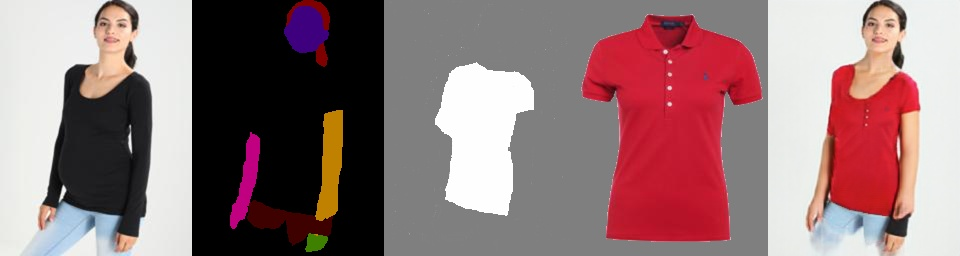

In [52]:
Image('sample/000001_0.jpg')

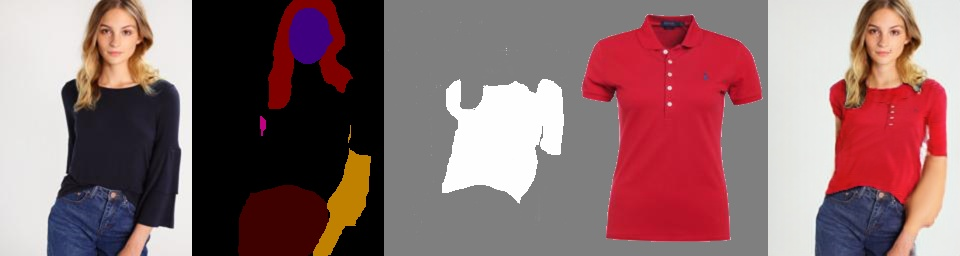

In [53]:
Image('sample/000010_0.jpg')


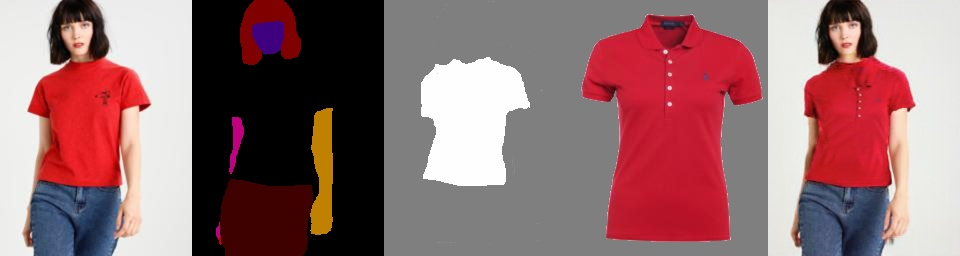

In [54]:
Image('sample/003935_0.jpg')

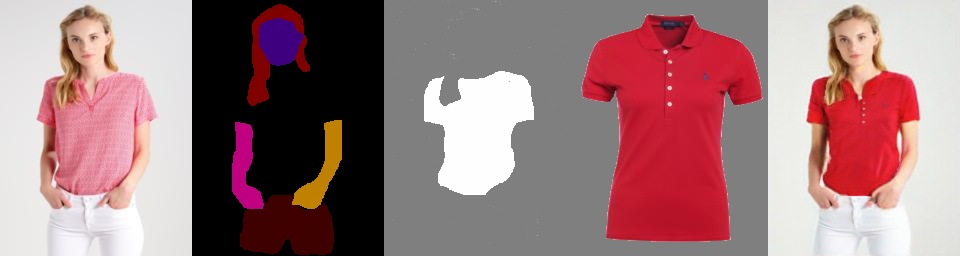

In [55]:
Image('sample/003821_0.jpg')

In [56]:
dir = '/content/drive/MyDrive/DeOldify/Project7/Denoising '
all_img = []
for dir_path,_,filenames in os.walk(dir):
  all_img.append(filenames)


### Current Dir Location

In [57]:
import os
directory = os.getcwd()
print(directory)

/kaggle/working/DeepFashion_Try_On/ACGPN_inference


In [58]:
dir = '/kaggle/working/DeepFashion_Try_On/ACGPN_inference/sample/'
results = []
for dir_path,_,filenames in os.walk(dir):
  results.append(filenames)

In [59]:
results = results[0]

In [60]:
results

['008429_0.jpg',
 '007949_0.jpg',
 '012712_0.jpg',
 '013060_0.jpg',
 '012487_0.jpg',
 '009114_0.jpg',
 '014025_0.jpg',
 '015516_0.jpg',
 '008110_0.jpg',
 '009689_0.jpg',
 '006768_0.jpg',
 '011577_0.jpg',
 '011761_0.jpg',
 '017348_0.jpg',
 '001083_0.jpg',
 '013642_0.jpg',
 '008871_0.jpg',
 '007932_0.jpg',
 '012934_0.jpg',
 '007781_0.jpg',
 '012149_0.jpg',
 '016562_0.jpg',
 '008188_0.jpg',
 '014240_0.jpg',
 '004989_0.jpg',
 '013309_0.jpg',
 '017315_0.jpg',
 '010003_0.jpg',
 '002691_0.jpg',
 '013456_0.jpg',
 '016309_0.jpg',
 '018327_0.jpg',
 '000560_0.jpg',
 '003963_0.jpg',
 '012174_0.jpg',
 '006606_0.jpg',
 '008151_0.jpg',
 '000118_0.jpg',
 '001606_0.jpg',
 '002317_0.jpg',
 '005110_0.jpg',
 '002511_0.jpg',
 '007045_0.jpg',
 '017555_0.jpg',
 '016094_0.jpg',
 '013181_0.jpg',
 '006859_0.jpg',
 '008551_0.jpg',
 '012785_0.jpg',
 '013583_0.jpg',
 '004580_0.jpg',
 '011699_0.jpg',
 '003787_0.jpg',
 '017410_0.jpg',
 '017982_0.jpg',
 '006452_0.jpg',
 '009435_0.jpg',
 '013233_0.jpg',
 '010976_0.jpg

In [61]:
!ls

__pycache__  grid_sample.py  one_map.jpg  sample	   util
checkpoints  im_pose.jpg     options	  test.py
data	     models	     runs	  tps_grid_gen.py


In [62]:
import random


In [63]:
# for i in range(0,1):
#     print(i)
#     random_result = random.choice(results)
#     Image('sample/'+str(random_result))

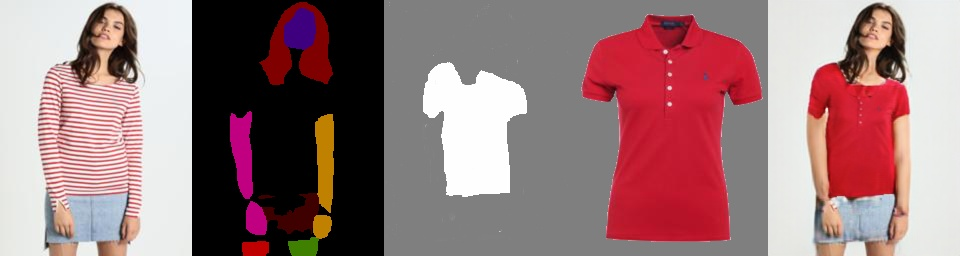

In [64]:
Image('sample/011769_0.jpg')


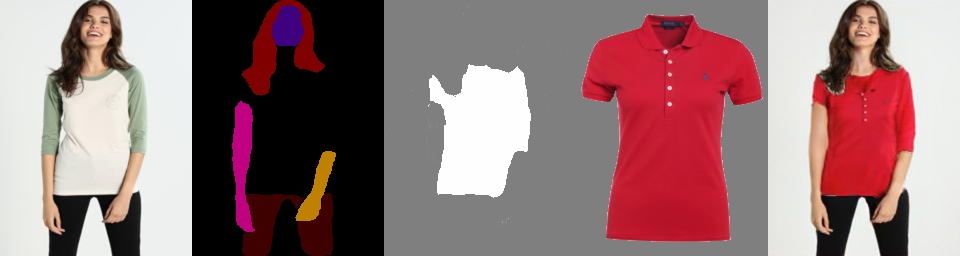

In [65]:

Image('sample/001236_0.jpg')


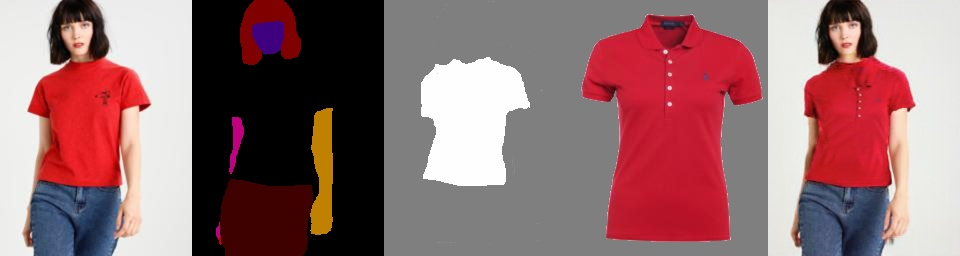

In [66]:
Image('sample/003935_0.jpg')